# Fashion-MNIST without external libraries 

#### Import packages and read the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# read the data and save labels
def read_data(data : str = 'train.csv') -> tuple[pd.DataFrame]:
    train_data, test_data = pd.read_csv(data), pd.read_csv('test.csv') 
    labels = train_data['label']    # save the labels
    train_data = train_data.loc[:, train_data.columns != 'label'] 
    return train_data, test_data, labels

train_data, test_data, labels = read_data()

In [3]:
true_labels =  ["TShirt",       # index 0
                "Trouser",      # index 1
                "Pullover",     # index 2 
                "Dress",        # index 3 
                "Coat",         # index 4
                "Sandal",       # index 5
                "Shirt",        # index 6 
                "Shoes",        # index 7 
                "Bag",          # index 8 
                "Boots"]        # index 9

### Visualize the Data

In [4]:
# find 4 images for each label in the dataset
def find_images(n_cols: int, n_labels: int = 10, image_size: int = 28) -> np.ndarray:
    j, image_count, index = 0, 0, 0
    data_to_visualize = np.zeros((n_labels * n_cols, image_size**2))

    for i in range(n_labels):
        while j < n_cols: 
            if i == labels[index]:
                data_to_visualize[image_count, :] = train_data.loc[index, :]
                image_count += 1
                j += 1
            index += 1
        j = 0
        index = 0
    return data_to_visualize

data_to_visualize = find_images(n_cols=4)

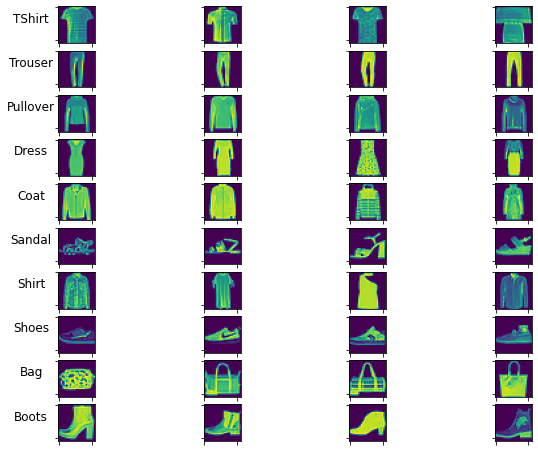

In [5]:
# plot the images found
def plot_examples(data_to_visualize: np.ndarray, n_cols: int, image_size: int=28) -> None:
    fig, axes = plt.subplots(10, 4, figsize=(10, 8))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        img = data_to_visualize[i, :].reshape(image_size, image_size)
        if i % n_cols == 0:
            ax.set_ylabel(true_labels[i // n_cols], rotation='horizontal', fontsize=12, labelpad=20.0)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.imshow(img)

plot_examples(data_to_visualize, n_cols=4)

### Logistic Regression Classifier

#### Foundation work on the data

In [6]:
# split train data into train and validate randomly
def split_data_into_train_val(val_part: float= 0.2) -> tuple[pd.DataFrame]:
    np.random.seed(0)
    rand_indexes = np.random.randint(low = 0, high=train_data.shape[0], size=int(train_data.shape[0]*val_part))
    x_val = train_data.loc[rand_indexes, :]
    y_val = labels[rand_indexes]
    x_train = train_data.drop(rand_indexes, axis=0)
    y_train = labels.drop(rand_indexes)
    x_test = test_data
    return x_train, y_train, x_val, y_val, x_test

x_train, y_train, x_val, y_val, x_test = split_data_into_train_val()

In [7]:
# normalize the data using min max normalization and training data
def normalize_data(x_train: pd.DataFrame, x_val: pd.DataFrame, x_test: pd.DataFrame) -> tuple[pd.DataFrame]:
    train_min = np.min(x_train, axis=0)
    train_max = np.max(x_train, axis=0)

    x_train = (x_train - train_min) / (train_max - train_min + 10e-6) 
    x_val = (x_val - train_min) / (train_max - train_min + 10e-6) 
    x_test = (x_test - train_min) / (train_max - train_min + 10e-6) 
    return x_train, x_val, x_test

x_train, x_val, x_test = normalize_data(x_train, x_val, x_test)

In [8]:
# use one-hot encoding
def one_hot_encoding(y_train: pd.Series, y_val: pd.Series, n_labels) -> tuple[pd.Series, pd.Series]:
    y_train_one_hot = np.zeros((y_train.size, n_labels))
    y_val_one_hot = np.zeros((y_val.size, n_labels))

    y_train_one_hot[np.arange(y_train.size), y_train.tolist()] = 1
    y_val_one_hot[np.arange(y_val.size), y_val.tolist()] = 1

    return y_train_one_hot, y_val_one_hot

y_train_one_hot, y_val_one_hot = one_hot_encoding(y_train, y_val, len(true_labels))

In [9]:
# add bias as another parameter
def add_bias_to_params(x_train: np.ndarray, x_val: np.ndarray, x_test: np.ndarray) -> tuple[np.ndarray]:
    x_train_full = np.zeros((x_train.shape[0], x_train.shape[1] + 1))
    x_val_full = np.zeros((x_val.shape[0], x_val.shape[1] + 1))
    x_test_full = np.zeros((x_test.shape[0], x_test.shape[1] + 1))
    x_train_full[:, :-1], x_train_full[:, -1] = x_train, np.ones((1, x_train.shape[0]))      
    x_val_full[:, :-1], x_val_full[:, -1] = x_val, np.ones((1, x_val.shape[0]))
    x_test_full[:, :-1], x_test_full[:, -1] = x_test, np.ones((1, x_test.shape[0]))
    return x_train_full, x_val_full, x_test_full

x_train_full, x_val_full, x_test_full = add_bias_to_params(x_train, x_val, x_test)

#### Implementing the Logistic Regression classifier

In [10]:
# helper functions for the logistic regression classifier
def softmax(z: np.ndarray) -> np.ndarray:
    numerator = np.exp(z - np.max(z, axis = 0))
    denominator = np.sum(np.exp(z - np.max(z, axis = 0)), axis = 0)
    return numerator / denominator

def cross_entropy(softmax_z: np.ndarray, y_train_one_hot: np.ndarray) -> np.ndarray:
    n = softmax_z.shape[1]
    loss = np.sum(np.log(softmax_z + 10e-8) * y_train_one_hot.T)
    return -loss / n

def derive_loss(softmax_z: np.ndarray, y_train_one_hot: np.ndarray, x_batch: np.ndarray) -> np.ndarray:
    n = softmax_z.shape[1]
    dL = (softmax_z - y_train_one_hot).T @ x_batch
    return dL / n

In [11]:
# implement the logistic regression classifier
class LogisticRegression:
    def __init__(self, batch_size, learning_rate, regularization_coefficient):
        self.bs = batch_size
        self.lr = learning_rate
        self.rc = regularization_coefficient
        self.train_loss, self.train_accuracy, self.validation_loss, self.validation_accuracy = ([] for _ in range(4))

    def train(self, n_labels: int = 10, epochs: int = 64) -> np.ndarray:
        n_samples = x_train_full.shape[0]  
        n_features = x_train_full.shape[1]  
        
        w = np.random.normal(loc=0.0, scale=0.01, size=(n_labels, n_features)) 
        n_batches = int(np.ceil(n_samples / self.bs))

        for _ in range(epochs):
            loss = 0
            accuracy = 0
            for chunk in range(n_batches):
                x_batch = x_train_full[chunk * self.bs: (chunk + 1) * self.bs, :]
                y_batch_onehot = y_train_one_hot[chunk * self.bs: (chunk + 1) * self.bs, :]
                z = w @ x_batch.T
                softmax_of_z = softmax(z)
                loss += cross_entropy(softmax_of_z, y_batch_onehot) + self.rc*np.sum(np.power(w, 2))
                predicts = np.argmax(softmax_of_z, axis = 0)
                accuracy += np.mean(np.equal(predicts, np.argmax(y_batch_onehot, axis = 1)))
                gradients = derive_loss(softmax_of_z.T, y_batch_onehot, x_batch) + 2 * self.rc * w
                w -= self.lr * gradients

            y_true = np.argmax(y_train_one_hot, axis = 1)
            y_pred = np.argmax(w @ x_train_full.T, axis = 0)
            train_acc_epoch = np.mean(np.equal(y_true, y_pred))
            train_loss_epoch = cross_entropy(softmax(w @ x_train_full.T),
                         y_train_one_hot) + self.rc * np.sum(np.power(w, 2)) 
            self.train_accuracy.append(train_acc_epoch)
            self.train_loss.append(train_loss_epoch)
        
            validation_acc_epoch, validation_loss_epoch = self._validate(w)
            self.validation_accuracy.append(validation_acc_epoch)
            self.validation_loss.append(validation_loss_epoch)
        
        self.plot(epochs)
        return w

    def _validate(self, w: np.ndarray) -> tuple[np.ndarray]:
        z = w @ x_val_full.T
        softmax_of_z = softmax(z)
        predicts = np.argmax(softmax_of_z, axis = 0)
        loss = cross_entropy(softmax_of_z, y_val_one_hot) + self.rc*np.sum(np.power(w, 2))
        accuracy = np.mean(np.equal(predicts, np.argmax(y_val_one_hot, axis = 1)))
        return accuracy, loss
            
    def test(self, w: np.ndarray) -> None:
        z = w @ x_test_full.T
        softmax_of_z = softmax(z)
        predicts = np.argmax(softmax_of_z, axis = 0)
        np.savetxt('lr_pred.csv', predicts, fmt='%i')

    def plot(self, epochs: int) -> None:
        steps = np.arange(epochs)
        fig, axs1 = plt.subplots()

        axs1.set_xlabel('epochs')
        axs1.set_ylabel('Accuracy')
        axs1.plot(steps, self.train_accuracy, label="train accuracy", color='blue')
        axs1.plot(steps, self.validation_accuracy, label="validation accuracy", color='black')
        axs2 = axs1.twinx()
        axs2.set_ylabel('Loss')
        axs2.plot(steps, self.train_loss, label="train loss", color='red')
        axs2.plot(steps, self.validation_loss, label="validation loss", color='green')

        fig.legend()

        print('Batch size: ' + str(self.bs) + '\nLearning rate: ' + str(self.lr) + '\nRegularization coefficient ' + str(self.rc))
        print('Train accuracy: ' + str(self.train_accuracy[-1])
             + '\nTrain loss: ' + str(self.train_loss[-1]))
        print('Validation accuracy: ' + str(self.validation_accuracy[-1]) 
             + '\nValidation loss: ' + str(self.validation_loss[-1]))
        
        plt.show()

Batch size: 128
Learning rate: 0.001
Regularization coefficient 1e-07
Train accuracy: 0.8595967302452316
Train loss: 0.41303494201018903
Validation accuracy: 0.850625
Validation loss: 0.43913972393539563


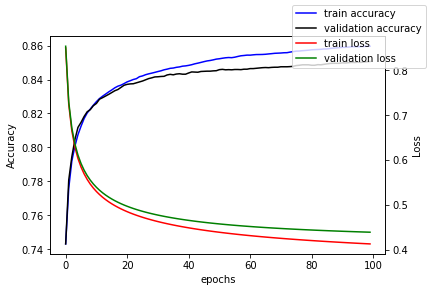

Batch size: 128
Learning rate: 0.001
Regularization coefficient 0.001
Train accuracy: 0.8591389645776567
Train loss: 0.5126533473120565
Validation accuracy: 0.8508035714285714
Validation loss: 0.537862835529088


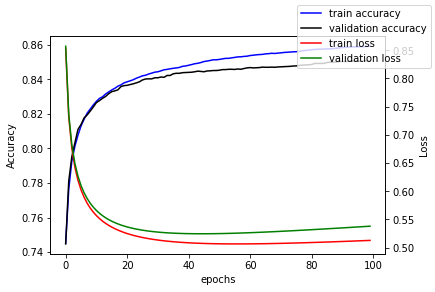

Batch size: 128
Learning rate: 0.05
Regularization coefficient 1e-07
Train accuracy: 0.8480435967302452
Train loss: 0.8322936865897468
Validation accuracy: 0.8267857142857142
Validation loss: 1.0157606072312524


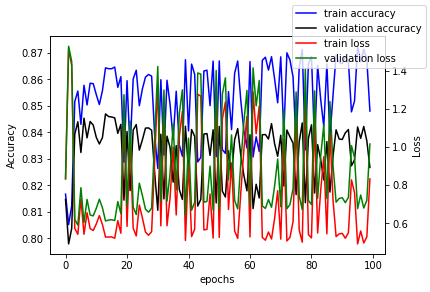

Batch size: 128
Learning rate: 0.05
Regularization coefficient 0.001
Train accuracy: 0.860882833787466
Train loss: 1.3299242151541253
Validation accuracy: 0.8419642857142857
Validation loss: 1.4289878737801938


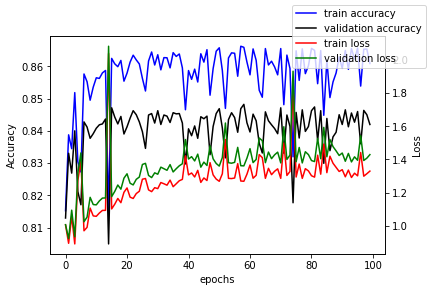

Batch size: 512
Learning rate: 0.001
Regularization coefficient 1e-07
Train accuracy: 0.8594005449591281
Train loss: 0.41326862230224526
Validation accuracy: 0.8507142857142858
Validation loss: 0.4393565334485853


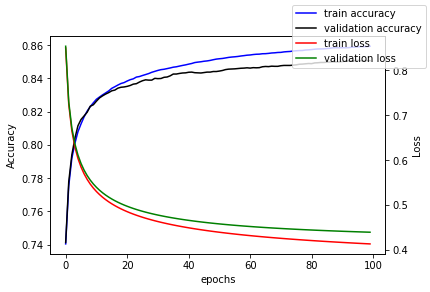

Batch size: 512
Learning rate: 0.001
Regularization coefficient 0.001
Train accuracy: 0.859465940054496
Train loss: 0.5151053963467453
Validation accuracy: 0.8498214285714286
Validation loss: 0.5407923956936075


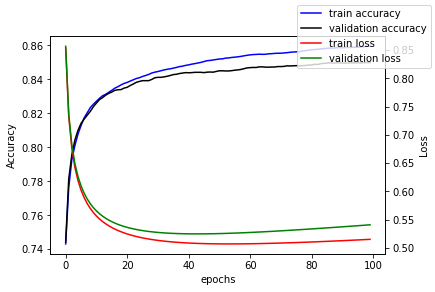

Batch size: 512
Learning rate: 0.05
Regularization coefficient 1e-07
Train accuracy: 0.8508555858310627
Train loss: 1.4053760720983304
Validation accuracy: 0.8298214285714286
Validation loss: 1.6351422561341062


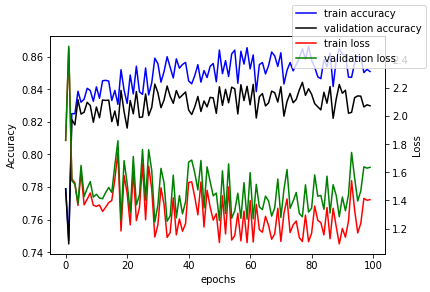

Batch size: 512
Learning rate: 0.05
Regularization coefficient 0.001
Train accuracy: 0.8559564032697548
Train loss: 7.839543594859931
Validation accuracy: 0.8349107142857143
Validation loss: 8.024605498127833


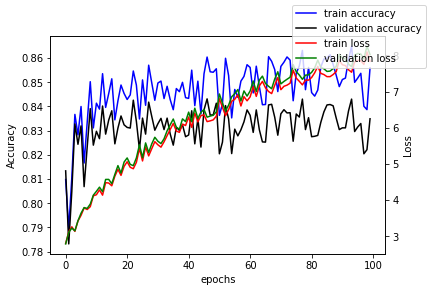

In [12]:
# hyper-parameter search
batch_sizes = [128, 512]
learning_rates = [0.001, 0.05]
regularization_coefficients = [10e-8, 10e-4]
w = []
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for regularization_coefficient in regularization_coefficients:
            Lr = LogisticRegression(batch_size, learning_rate, regularization_coefficient) 
            w.append(Lr.train(epochs=100))

Batch size: 128
Learning rate: 0.001
Regularization coefficient 1e-07
Train accuracy: 0.8665940054495913
Train loss: 0.3917525627043102
Validation accuracy: 0.8557142857142858
Validation loss: 0.4281320071506817


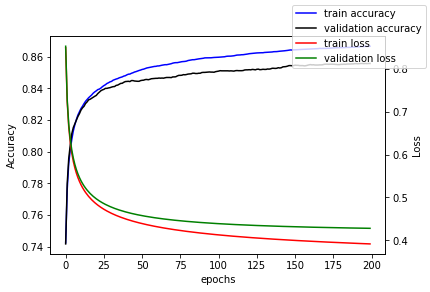

In [13]:
# test and save the results of the best logistic regression classifier
LR = LogisticRegression(batch_size=128, learning_rate=0.001, regularization_coefficient=10e-8) 
w = LR.train(epochs=200)
LR.test(w)

### Neural Network with One Hidden Layer

In [14]:
# different activation functions for the neural network
def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-z))

def derive_sigmoid(z: np.ndarray) -> np.ndarray:
    return sigmoid(z) * (1 - sigmoid(z))

def relu(z: np.ndarray) -> np.ndarray:
    return np.maximum(z, 0)

def derive_relu(z: np.ndarray) -> np.ndarray:
    derive = np.zeros(z.shape)
    derive[z > 0] = 1
    return derive

In [15]:
x_train = x_train.to_numpy()
x_val = x_val.to_numpy()
x_test = x_test.to_numpy()

In [16]:
# implement the neural network 
class NeuralNetwork:
    def __init__(self, bat_size: int, lear_rate: float, regu_coef: float, activ_func, h_size:int, dropout: bool, drop_prob: int = 0.2):
        self.batch_size = bat_size
        self.learn_rate = lear_rate
        self.regu_coef = regu_coef
        self.activation = activ_func
        self.hidden_size = h_size
        self.dropout = dropout
        self.drop_prob = drop_prob
        self.train_loss, self.train_accuracy, self.validation_loss, self.validation_accuracy = ([] for _ in range(4))

    def train(self, n_labels: int = 10, epochs: int = 128) -> np.ndarray:
        n_samples = x_train.shape[0]  
        n_features = x_train.shape[1]  

        n_batches = int(np.ceil(n_samples / self.batch_size))
        w1 = np.random.normal(loc=0.0, scale=0.01, size=(self.hidden_size, n_features)) 
        b1 = np.zeros((self.hidden_size, 1))
        w2 = np.random.normal(loc=0.0, scale=0.01, size=(self.hidden_size, n_labels)) 
        b2 = np.zeros((n_labels, 1))

        for _ in range(epochs):
            loss = 0
            accuracy = 0
            for batch in range(n_batches):
                x_batch = x_train[batch * self.batch_size: (batch + 1) * self.batch_size, :]
                y_batch_onehot = y_train_one_hot[batch * self.batch_size: (batch + 1) * self.batch_size, :]
                z1 = w1 @ x_batch.T + b1
                h = self.activation(z1)
                y_hat = softmax(w2.T @ h + b2)
                loss += cross_entropy(y_hat, y_batch_onehot) + self.regu_coef*np.sum(np.power(w, 2))
                predicts = np.argmax(y_hat, axis = 0)
                accuracy += np.mean(np.equal(predicts, np.argmax(y_batch_onehot, axis = 1)))

                if self.dropout: 
                    drop_idx = np.random.randint(0,h.shape[0], int(self.hidden_size * self.drop_prob)) 
                    mask = np.ones((h.shape[0], 1))
                    mask[drop_idx, 0] = 0
                    h = h * mask
                
                # derive gradients using the quotient rule of derivatives
                diff = y_hat.T - y_batch_onehot
                dLdb2 = (1 / n_samples) * np.sum(diff, axis=0, keepdims=True)
                dLdw2 = (1 / n_samples) * h @ diff

                dLdh = diff @ w2.T
                if self.activation == relu:
                    dLdz1 = dLdh * derive_relu(z1).T
                if self.activation == sigmoid:
                    dLdz1 = dLdh * derive_sigmoid(z1).T

                dLdw1 = (1 / n_samples) * (dLdz1.T @ x_batch)
                dLdb1 = (1 / n_samples) * np.sum(dLdz1, axis=0, keepdims=True)

                # gradient descent
                w2 -= self.learn_rate * (dLdw2 + 2 * self.regu_coef * w2)
                b2 -= self.learn_rate * dLdb2.T
                w1 -= self.learn_rate * (dLdw1 + 2 * self.regu_coef * w1)  
                b1 -= self.learn_rate * dLdb1.T
            
            y_true = np.argmax(y_train_one_hot, axis = 1)
            h = self.activation(w1 @ x_train.T + b1)
            y_hat = softmax(w2.T @ h + b2)
            y_pred = np.argmax(y_hat, axis = 0)

            train_acc_epoch = np.mean(np.equal(y_true, y_pred))
            train_loss_epoch = cross_entropy(y_hat, y_train_one_hot) + self.regu_coef * (np.sum(np.power(w1, 2)) + np.sum(np.power(w2, 2))) 
            self.train_accuracy.append(train_acc_epoch)
            self.train_loss.append(train_loss_epoch)

            validation_acc_epoch, validation_loss_epoch = self._validate(w1, w2, b1, b2)
            self.validation_accuracy.append(validation_acc_epoch)
            self.validation_loss.append(validation_loss_epoch)
        
        self.plot(epochs)
        if self.dropout:
            w1, w2, b1, b2 = (1-self.drop_prob)*w1, (1-self.drop_prob)*w2, (1-self.drop_prob)*b1, (1-self.drop_prob)*b2
        return w1, b1, w2 ,b2 
            

    def _validate(self, w1, w2, b1, b2) -> tuple[np.ndarray, np.ndarray]:
        h = self.activation(w1 @ x_val.T + b1)
        y_hat = softmax(w2.T @ h + b2)
        y_pred = np.argmax(y_hat, axis = 0)
        loss = cross_entropy(y_hat, y_val_one_hot) + self.regu_coef * (np.sum(np.power(w1, 2)) + np.sum(np.power(w2, 2))) 
        accuracy = np.mean(np.equal(y_pred, np.argmax(y_val_one_hot, axis = 1)))
        return accuracy, loss

    def test(self, w1, b1, w2, b2) -> None:
        h = self.activation(w1 @ x_test.T + b1)
        y_hat = softmax(w2.T @ h + b2)
        y_pred = np.argmax(y_hat, axis = 0)
        np.savetxt('NN_pred.csv', y_pred, fmt='%i')

    def plot(self, epochs: int) -> None:
        steps = np.arange(epochs)
        fig, axs1 = plt.subplots()

        axs1.set_xlabel('epochs')
        axs1.set_ylabel('Accuracy')
        axs1.plot(steps, self.train_accuracy, label="train accuracy", color='blue')
        axs1.plot(steps, self.validation_accuracy, label="validation accuracy", color='black')
        axs2 = axs1.twinx()
        axs2.set_ylabel('Loss')
        axs2.plot(steps, self.train_loss, label="train loss", color='red')
        axs2.plot(steps, self.validation_loss, label="validation loss", color='green')

        fig.legend()

        print('Batch size: ' + str(self.batch_size) + '\nLearning rate: ' + str(self.learn_rate) + '\nRegularization coefficient ' + str(self.regu_coef) 
             + '\nActivation Function ' + str(self.activation) + '\nHidden Size ' + str(self.hidden_size) + '\nDropout ' + str(self.dropout))
        print('Train accuracy: ' + str(self.train_accuracy[-1])
             + '\nTrain loss: ' + str(self.train_loss[-1]))
        print('Validation accuracy: ' + str(self.validation_accuracy[-1]) 
             + '\nValidation loss: ' + str(self.validation_loss[-1]))
        
        plt.show()
    

Batch size: 128
Learning rate: 0.5
Regularization coefficient 1e-08
Activation Function <function relu at 0x00000261FB928E50>
Hidden Size 256
Dropout True
Train accuracy: 0.8247193460490463
Train loss: 0.516947404035578
Validation accuracy: 0.8248214285714286
Validation loss: 0.5277511405927275


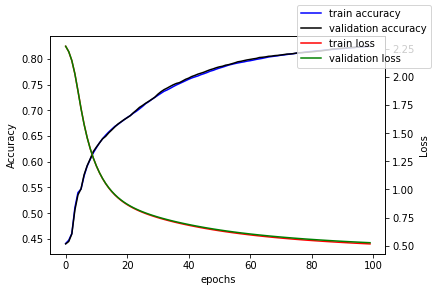

Batch size: 128
Learning rate: 0.5
Regularization coefficient 1e-08
Activation Function <function relu at 0x00000261FB928E50>
Hidden Size 256
Dropout False
Train accuracy: 0.8284468664850136
Train loss: 0.5043010627734709
Validation accuracy: 0.8270535714285714
Validation loss: 0.5148847489341223


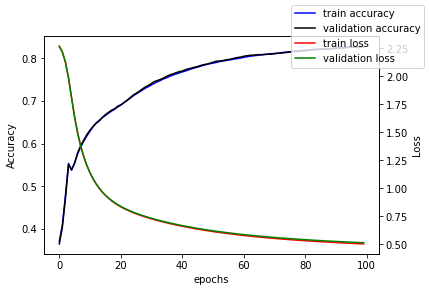

Batch size: 128
Learning rate: 0.5
Regularization coefficient 1e-08
Activation Function <function relu at 0x00000261FB928E50>
Hidden Size 10
Dropout True
Train accuracy: 0.7885558583106267
Train loss: 0.6013822127501642
Validation accuracy: 0.789375
Validation loss: 0.612296377442506


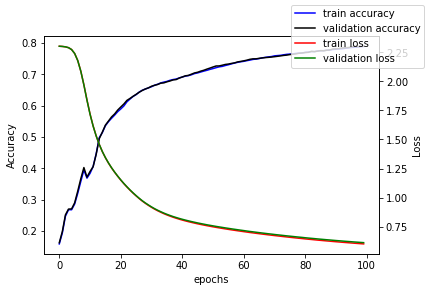

Batch size: 128
Learning rate: 0.5
Regularization coefficient 1e-08
Activation Function <function relu at 0x00000261FB928E50>
Hidden Size 10
Dropout False
Train accuracy: 0.7903433242506812
Train loss: 0.6071635326815715
Validation accuracy: 0.7900892857142857
Validation loss: 0.6176837914906955


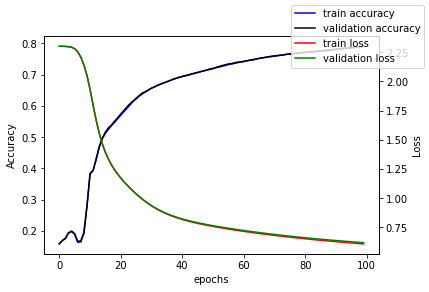

Batch size: 128
Learning rate: 0.5
Regularization coefficient 1e-08
Activation Function <function sigmoid at 0x00000261FB928F70>
Hidden Size 256
Dropout True
Train accuracy: 0.7235967302452316
Train loss: 0.8289590318285678
Validation accuracy: 0.7221428571428572
Validation loss: 0.8367721851273291


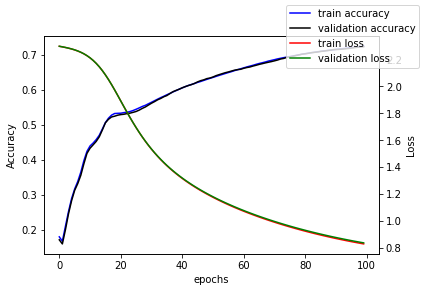

Batch size: 128
Learning rate: 0.5
Regularization coefficient 1e-08
Activation Function <function sigmoid at 0x00000261FB928F70>
Hidden Size 256
Dropout False
Train accuracy: 0.7253405994550409
Train loss: 0.7970324463416412
Validation accuracy: 0.7253571428571428
Validation loss: 0.8056309555025571


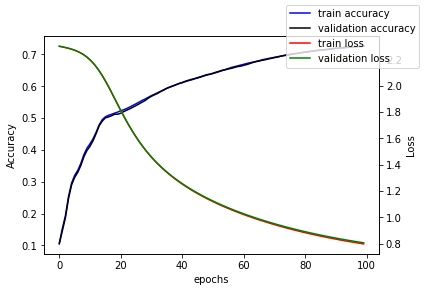

Batch size: 128
Learning rate: 0.5
Regularization coefficient 1e-08
Activation Function <function sigmoid at 0x00000261FB928F70>
Hidden Size 10
Dropout True
Train accuracy: 0.5550299727520436
Train loss: 1.3688795029911973
Validation accuracy: 0.5552678571428571
Validation loss: 1.3707205733885417


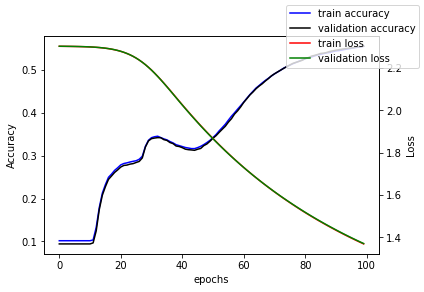

Batch size: 128
Learning rate: 0.5
Regularization coefficient 1e-08
Activation Function <function sigmoid at 0x00000261FB928F70>
Hidden Size 10
Dropout False
Train accuracy: 0.5573623978201635
Train loss: 1.33588983280312
Validation accuracy: 0.5584821428571428
Validation loss: 1.3390347576911787


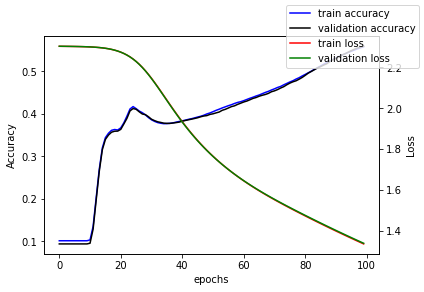

In [17]:
# hyper-parameter search
batch_sizes = [128]
learning_rates = [0.5]
regularization_coefficients = [1e-08]
activation_functions = [relu, sigmoid]
h_sizes = [256, 10]
dropout = [True, False]
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for regularization_coefficient in regularization_coefficients:
            for activation_function in activation_functions:
                for h_size in h_sizes:
                    for drop in dropout:
                        NN = NeuralNetwork(batch_size,learning_rate,regularization_coefficient, activation_function, h_size, drop, 0.2)
                        w1_i, b1_i, w2_i, b2_i = NN.train(epochs=100)

Batch size: 128
Learning rate: 0.5
Regularization coefficient 1e-08
Activation Function <function relu at 0x00000261FB928E50>
Hidden Size 256
Dropout True
Train accuracy: 0.8465613079019073
Train loss: 0.4443476604062343
Validation accuracy: 0.8425892857142857
Validation loss: 0.46090127442122547


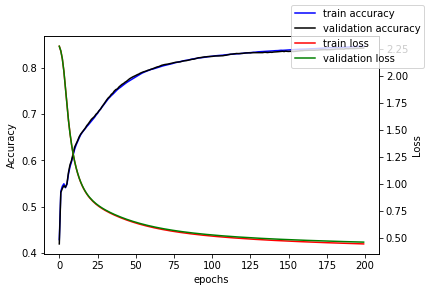

In [19]:
# test and save the fittest neural network
NN = NeuralNetwork(128, 0.5, 1e-08, relu, 256,  True, 0.2)
w1, b1, w2, b2 = NN.train(epochs=200)
NN.test(w1, b1, w2, b2)